In [1]:
from imports import *
from periodogram import compute_LSperiodogram
from read_data import *
from bgls import bgls
from rvmodel import get_rv1
from priors import *
from autocorrDFM import *
%matplotlib inline

In [16]:
# get data
fullRVs = True
bjd, rv, erv, program, bjdshort, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS(fullRVs)


# remove bad points known from loocv
badRVs = np.array([63])
g = np.delete(np.arange(bjd.size), badRVs)
#bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = \
#bjd[g],rv[g],erv[g],fwhm[g],bis[g],Halpha[g],eHalpha[g],Hbeta[g],eHbeta[g],Hgamma[g],eHgamma[g],NaD[g],eNaD[g],Sindex[g],eSindex[g]
bjd, rv, erv, program = bjd[g],rv[g],erv[g], program[g]
Binds = program == 'Bonfils'
Jinds = program == 'Jenkins'
Zinds = program == 'Berdinas'
print bjd.size, program.size

-5678.38
164 164


## visualize data

<Container object of 3 artists>

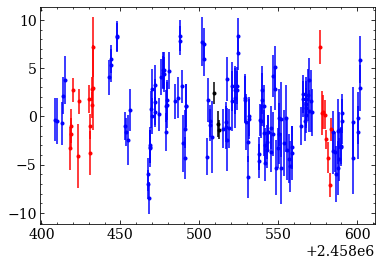

In [23]:
# plot RVs
plt.errorbar(bjd[Binds], rv[Binds], erv[Binds], fmt='b.')
plt.errorbar(bjd[Jinds], rv[Jinds], erv[Jinds], fmt='r.')
plt.errorbar(bjd[Zinds], rv[Zinds], erv[Zinds], fmt='k.')

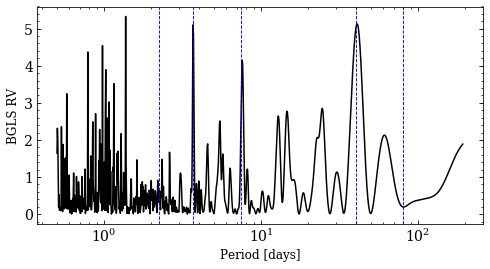

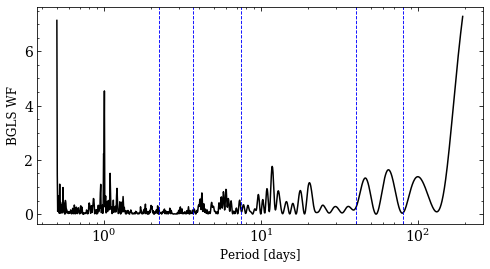

In [24]:
# plot periograms
Prot = 80
Ps = [2.25,3.69,7.45,Prot,Prot/2.]
xs = [bjd, bjd]#, bjd, bjd, bjd, bjd, bjd, bjd, bjd]
ys = [rv, bjd]#, fwhm, bis, Halpha, Hbeta, Hgamma, NaD, Sindex]
eys = [erv, erv]#, np.ones(bjd.size), np.ones(bjd.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
labels = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
for i in range(len(xs)):
    #per,pwr = bgls(xs[i], ys[i], eys[i], plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
    per,_,pwr = compute_LSperiodogram(xs[i], ys[i], eys[i], plims=(.5,bjd.max()-bjd.min()))
    plt.figure(i, figsize=(8,4))
    plt.plot(per, pwr, 'k-'), plt.xscale('log')
    plt.ylabel('BGLS %s'%labels[i], fontsize=12), plt.xlabel('Period [days]', fontsize=12)
    for p in Ps:
        plt.axvline(p, ls='--', lw=.9, color='b')

## run MCMC assuming a 3-planet model

In [25]:
def hk2ew(h, k):
    ecc = h*h + k*k
    omega = np.arctan2(k,h)
    return ecc, omega


def full_model(theta, bjd, rv, erv):
    # get params
    assert len(theta) == 21
    agp, lgp, Ggp, Pgp = np.exp(theta[:4])
    s, V, P1, T01, K1, h1, k1, P2, T02, K2, h2, k2, P3, T03, K3, h3, k3 = theta[4:]
    # compute GPs
    kern1 = george.kernels.ExpSquaredKernel(lgp)
    kern2 = george.kernels.ExpSine2Kernel(Ggp, Pgp)
    gp = george.GP(agp*kern1*kern2)
    try:
        gp.compute(bjd, np.sqrt(erv**2+s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    # get models
    kep1 = get_rv1((P1,T01,0,K1,h1,k1), bjd)
    kep2 = get_rv1((P2,T02,0,K2,h2,k2), bjd)
    kep3 = get_rv1((P3,T03,0,K3,h3,k3), bjd)
    mu, cov = gp.predict(rv-V-kep1-kep2-kep3, bjd)
    sig = np.sqrt(np.diag(cov))
    return gp, mu, sig, V, kep1, kep2, kep3

In [26]:
def lnlike(theta, bjd, rv, erv):
    p = full_model(theta, bjd, rv, erv)
    if len(p) == 0:
        return -np.inf
    gp, mu, sig, V, kep1, kep2, kep3 = p
    return gp.lnlikelihood(rv-V-kep1-kep2-kep3, quiet=True)

In [27]:
def lncustom_int(x, fint):
    try:
        return np.log(fint(x))
    except ValueError:
        return -np.inf


def lnprior(theta, int_l, int_G, int_P):
    assert len(theta) == 21
    lna,lnl,lnG,lnP,s,V,P1,T01,K1,h1,k1,P2,T02,K2,h2,k2,P3,T03,K3,h3,k3 = theta
    lps = np.zeros(21)
    
    lps[0] = lnuniform(lna, -5, 5)
    lps[1] = lncustom_int(lnl, int_l)
    lps[2] = lncustom_int(lnG, int_G)
    lps[3] = lncustom_int(lnP, int_P)
    
    lps[4] = lnjeffreysprior(s, 1e-2, 10)
    lps[5] = lnuniform(V, -3, 3)
    
    lps[6] = lngaussian(P1, 3.69040, 2.5e-4) # Kostov
    lps[7] = lngaussian(T01, 2458367.2751, 6e-4)  # Kostov
    lps[8] = lnjeffreysprior(K1, .1, 10)
    lps[9] = lnuniform(h1, -1, 1) if hk2ew(h1,k1)[0] < 1 else -np.inf
    lps[10] = lnuniform(k1, -1, 1) if hk2ew(h1,k1)[0] < 1 else -np.inf

    lps[11] = lngaussian(P2, 7.4513, 7e-4) # Kostov
    lps[12] = lngaussian(T02, 2458362.7375, 8e-4)  # Kostov
    lps[13] = lnjeffreysprior(K2, .1, 10)
    lps[14] = lnuniform(h2, -1, 1) if hk2ew(h2,k2)[0] < 1 else -np.inf
    lps[15] = lnuniform(k2, -1, 1) if hk2ew(h2,k2)[0] < 1 else -np.inf

    lps[16] = lngaussian(P3, 2.2532, 3e-4) # Kostov
    lps[17] = lngaussian(T03, 2458366.1708, 1e-4)  # Kostov
    lps[18] = lnjeffreysprior(K3, .1, 10)
    lps[19] = lnuniform(h3, -1, 1) if hk2ew(h3,k3)[0] < 1 else -np.inf
    lps[20] = lnuniform(k3, -1, 1) if hk2ew(h3,k3)[0] < 1 else -np.inf

    return lps.sum()

In [28]:
def lnprob(theta, bjd, rv, erv, int_l, int_G, int_P):
    lp = lnprior(theta, int_l, int_G, int_P)
    if np.isfinite(lp):
        lprob = lp + lnlike(theta, bjd, rv, erv)
        return lprob if np.isfinite(lprob) else -np.inf
    else:
        return -np.inf

In [29]:
def run_emcee(theta, bjd,rv,erv, samples_lGP,lnlarr,lnGarr,lnParr, initialize,
              nwalkers=100, burnin=200, nsteps=200, a=1.8):
    
    ndim, p0 = len(theta), []
    assert len(initialize) == ndim
    for i in range(nwalkers):
        p0.append(theta + initialize*np.random.randn(ndim))
            
    assert samples_lGP.shape[1] == 3
    KDE_l = gaussian_kde(samples_lGP[:,0]).pdf(lnlarr)
    KDE_G = gaussian_kde(samples_lGP[:,1]).pdf(lnGarr)
    KDE_P = gaussian_kde(samples_lGP[:,2]).pdf(lnParr)
    int_l = interp1d(lnlarr, KDE_l)
    int_G = interp1d(lnGarr, KDE_G)
    int_P = interp1d(lnParr, KDE_P)
    
    args = (bjd,rv,erv, int_l,int_G,int_P)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, a=a)
    
    print '\nRunning Burnin...'
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burnin acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burnin took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()
    
    print 'Running MCMC...'
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print "Mean acceptance fraction: %.4f"%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes'%((time.time()-t0)/60.)
    samples = sampler.chain.reshape((-1, ndim))
    results = get_results(samples)
    
    return sampler, samples, results

In [30]:
# run mcmc
theta = np.log(2), 8, 0, np.log(40)
theta = np.append(theta, [1e-1,0])
theta = np.append(theta, [3.69040,2458367.2751,2,0,0])
theta = np.append(theta, [7.4513,2458362.7375,2,0,0])
theta = np.append(theta, [2.2532,2458366.1708,.5,0,0])

initialize = 1e-1, 1e-1, 1e-1, 1e-1
initialize = np.append(initialize, [1e-2,1e-2])
initialize = np.append(initialize, [1e-4,1e-4,1e-1,1e-2,1e-2])
initialize = np.append(initialize, [1e-4,1e-4,1e-1,1e-2,1e-2])
initialize = np.append(initialize, [1e-4,1e-4,1e-1,1e-2,1e-2])

samples_lGP = np.loadtxt('output_data/GPsamples_Halpha.dat')[:,1:4]
samples_lGP[:,2] = np.log(.5*np.exp(samples_lGP[:,2]))   # set to Prot/2
lnlarr, lnGarr, lnParr = np.linspace(0,30,100), np.linspace(-5,2,100), np.linspace(1,4,100)

sampler, samples, results = run_emcee(theta, bjd,rv,erv, samples_lGP, lnlarr,lnGarr,lnParr, initialize,
                                      nwalkers=300, burnin=200, nsteps=500)


Running Burnin...


/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/priors.py:10: RuntimeWarning: invalid value encountered in log
  return np.log(pri)


Burnin acceptance fraction is 0.2480
Burnin took 33.5129 minutes

Running MCMC...
Mean acceptance fraction: 0.1586
Full MCMC took 97.8554 minutes


In [31]:
# save samples
hdu = fits.PrimaryHDU(samples)
hdu.writeto('output_data/3planets_TOI175_H164_HalphaGP_samplesv1', overwrite=True)
hdu = fits.PrimaryHDU(sampler.lnprobability)
hdu.writeto('output_data/3planets_TOI175_H164_HalphaGP_lnprobsv1', overwrite=True)

#samples = fits.open('output_data/3planets_TOI175_H161_HalphaGP_samplesv1')[0].data
#results = get_results(samples)

In [32]:
tau, Nsteps = autocorr_time_DFM(sampler.chain)
print '10 auto-correlation times = %.3f'%(tau*10)
print 'Actual length of chains = %i (i.e. %.2f auto-correlation times)'%(Nsteps,Nsteps/tau)

10 auto-correlation times = 507.393
Actual length of chains = 500 (i.e. 9.85 auto-correlation times)


## plot results

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


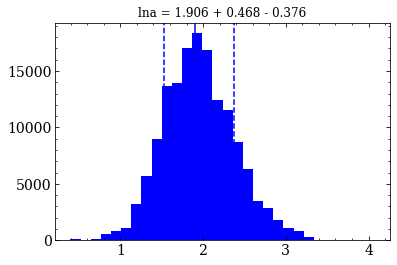

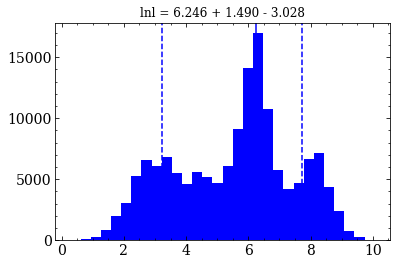

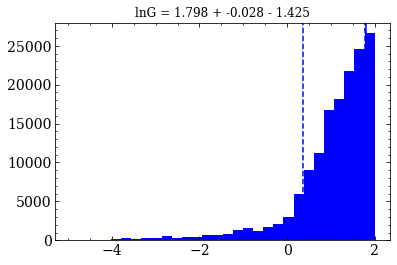

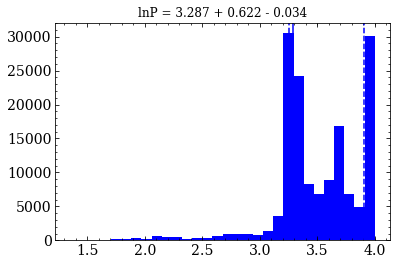

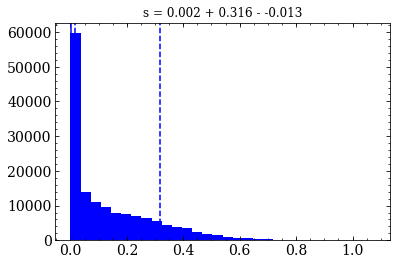

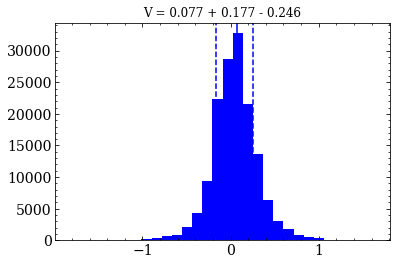

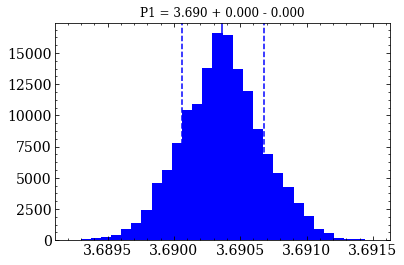

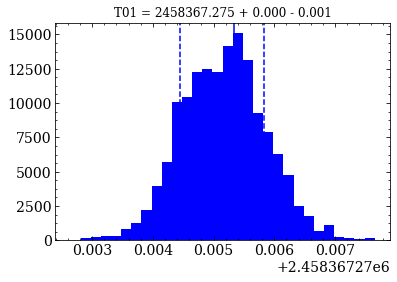

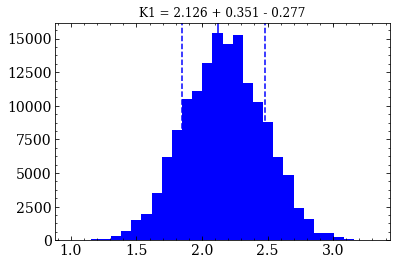

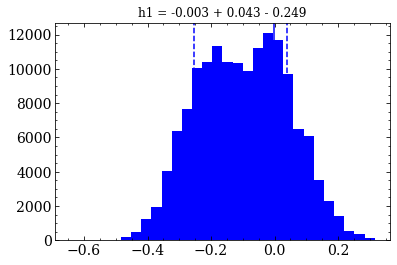

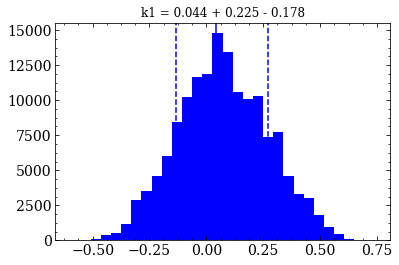

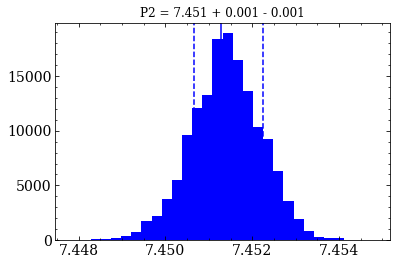

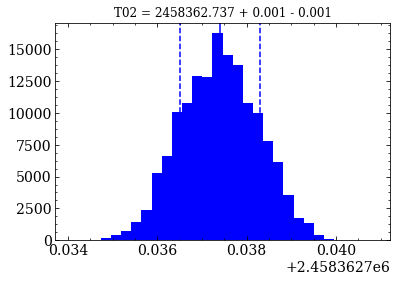

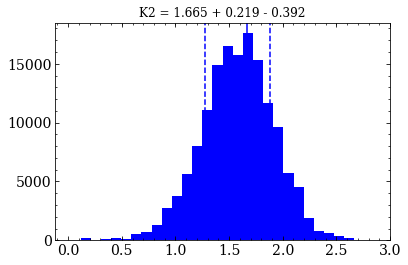

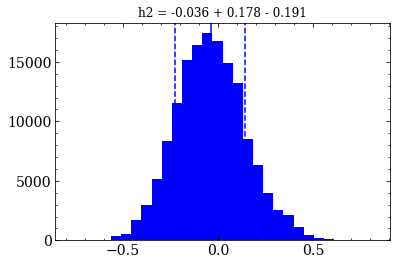

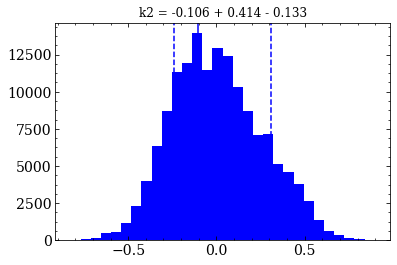

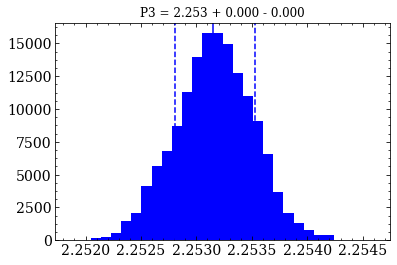

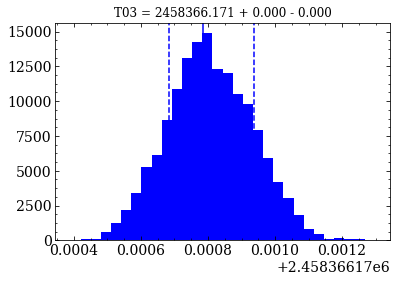

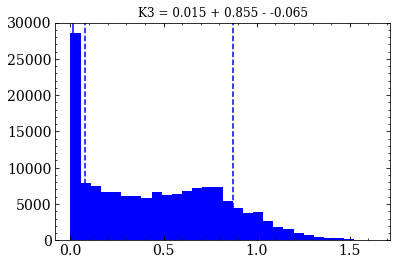

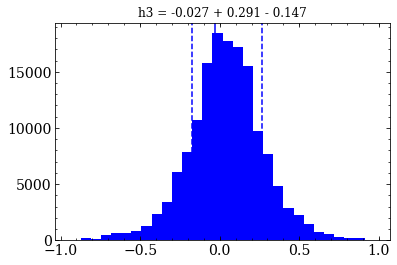

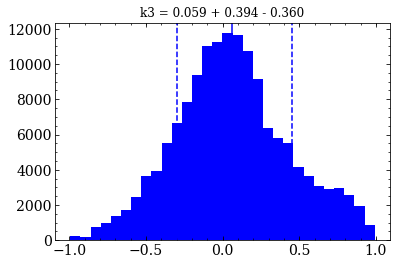

In [33]:
labels = ['lna','lnl','lnG','lnP','s','V','P1','T01','K1','h1','k1','P2','T02','K2','h2','k2', \
          'P3','T03','K3','h3','k3']
g = np.arange(samples.shape[0])
for i in range(samples.shape[1]):
    plt.figure(i)
    plt.hist(samples[g,i], bins=30)
    m,ps,ms = results[:,i]
    plt.axvline(m), plt.axvline(m-ms,ls='--'), plt.axvline(m+ps,ls='--')
    plt.title('%s = %.3f + %.3f - %.3f'%(labels[i],m,ps,ms))

In [34]:
# report planet parameters
Ms, Rs = unp.uarray(0.3124, 0.031), unp.uarray(0.3137, 0.014)
Teff = unp.uarray(3412, 49)

P1 = unp.uarray(results[0,6], results[1:,6].mean())
K1 = unp.uarray(results[0,8], results[1:,8].mean())
P2 = unp.uarray(results[0,11], results[1:,11].mean())
K2 = unp.uarray(results[0,13], results[1:,13].mean())
P3 = unp.uarray(results[0,16], results[1:,16].mean())
v = np.percentile(samples[:,18], (16,50,84))
K3 = unp.uarray(v[1], v[2]-v[1])

mp1 = rvs.RV_mp(P1, Ms, K1)
mp2 = rvs.RV_mp(P2, Ms, K2)
mp3 = rvs.RV_mp(P3, Ms, K3)

rpRs1 = unp.uarray(0.0400, 2e-3)  # Kostov
rpRs2 = unp.uarray(0.0431, 3e-3)  # Kostov
rpRs3 = unp.uarray(0.0226, 1.3e-3)  # Kostov

rp1 = rvs.m2Rearth(rvs.Rsun2m(Rs*rpRs1))
rp2 = rvs.m2Rearth(rvs.Rsun2m(Rs*rpRs2))
rp3 = rvs.m2Rearth(rvs.Rsun2m(Rs*rpRs3))
rho1 = 5.55 * mp1 / rp1**3
rho2 = 5.55 * mp2 / rp2**3
rho3 = 5.55 * mp3 / rp3**3

print P1, K1, mp1, rp1, rho1
print P2, K2, mp2, rp2, rho2
print P3, K3, mp3, rp3, rho3

3.69036+/-0.00031 2.13+/-0.31 2.4+/-0.4 1.37+/-0.09 5.1+/-1.3
7.4513+/-0.0008 1.67+/-0.31 2.3+/-0.5 1.48+/-0.12 4.0+/-1.3
2.2531+/-0.0004 0.4+/-0.4 0.4+/-0.4 0.77+/-0.06 5+/-5


In [ ]:
samp_rp = np.random.randn(samples.shape[0])*.05+.8
samp_mp = rvs.RV_mp(samples[:,16], np.random.randn(samples.shape[0])*.031+.3124, samples[:,18])
samp_rho = 5.55*samp_mp/samp_rp**3
samp_g = 9.80665*samp_mp / samp_rp**2
samp_vesc = 11.2 * (samp_mp / samp_rp)**(.5)
np.percentile(samp_vesc, 95)
#_=plt.hist(samp_mp, bins=30)

In [67]:
np.median(samples[:,18])

0.4318302488916681

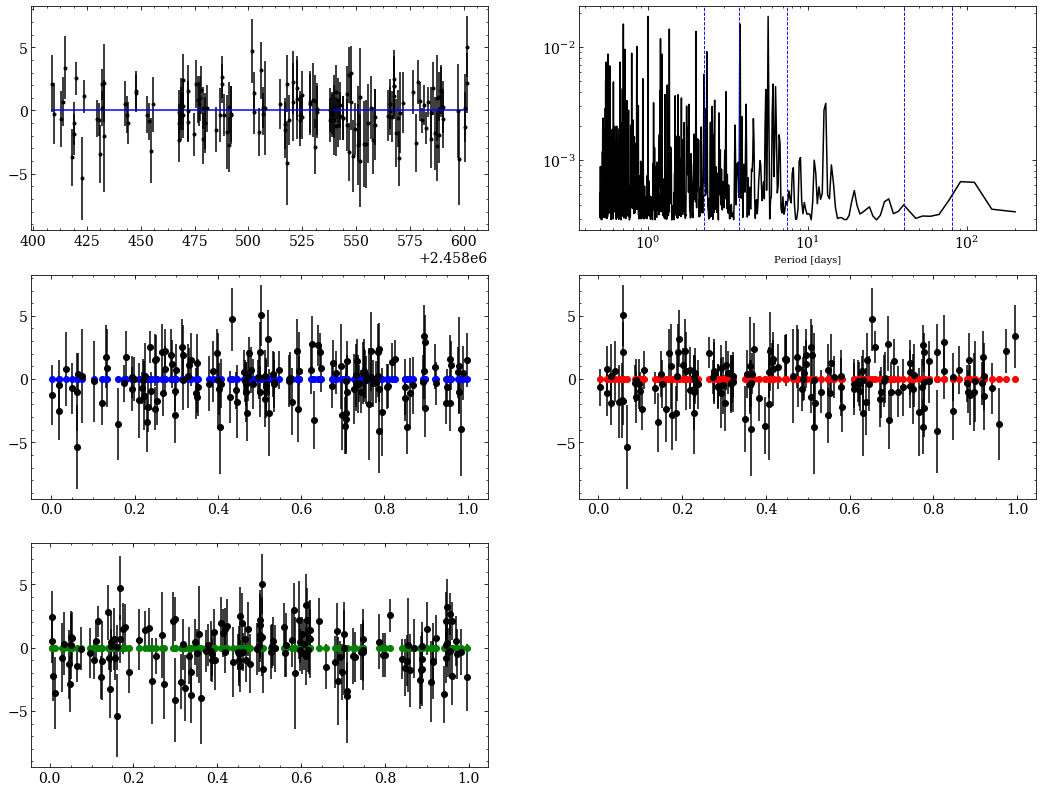

In [22]:
# plot phase-folded RVs
theta = np.copy(results[0])
theta[18] = float(unp.nominal_values(K3))
gp, mu, sig, V, kep1, kep2, kep3 = full_model(theta, bjd, rv, erv)

phase1 = foldAt(bjd, unp.nominal_values(P1), results[0,7])
phase2 = foldAt(bjd, unp.nominal_values(P2), results[0,12])
phase3 = foldAt(bjd, unp.nominal_values(P3), results[0,17])

xarr = bjd
yarr = rv-V-mu-kep1-kep3-kep2
marr = kep2*0

plt.figure(figsize=(18,14))
plt.subplot(321)
s = np.argsort(xarr)
plt.errorbar(xarr, yarr, erv, fmt='k.', capsize=0)
plt.plot(xarr[s], marr[s], 'b-')

# periodogram
per,prob = bgls(bjd, yarr, erv, plow=.5, phigh=200, n_steps=1e3)
plt.subplot(322)
plt.plot(per, prob, 'k-'), plt.xscale('log'), plt.yscale('log')
for p in Ps:
    plt.axvline(p, ls='--', lw=.9)
plt.xlabel('Period [days]')

# phase-folded
plt.subplot(323)
plt.errorbar(phase1, yarr, erv, fmt='ko')
plt.plot(phase1, marr, 'bo')

plt.subplot(324)
plt.errorbar(phase2, yarr, erv, fmt='ko')
plt.plot(phase2, marr, 'ro')

plt.subplot(325)
plt.errorbar(phase3, yarr, erv, fmt='ko')
plt.plot(phase3, marr, 'go')

In [72]:
results[:,4]

array([ 1.36862747e-07,  2.56760982e-01, -1.28185614e-02])

## manually get parameters for the paper table

(1.5920712719222732,
 0.31905188184417566,
 0.3339407206496179,
 0.32649630124689677)

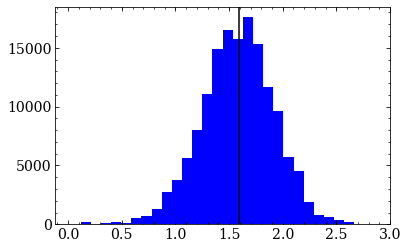

In [39]:
s = samples[:,13]
_=plt.hist(s, bins=30)

v = np.percentile(s, (16,50,84))
plt.axvline(v[1], color='k')
v[1], v[2]-v[1], v[1]-v[0], abs(v[1]-np.array([v[2],v[0]])).mean()

In [62]:
np.percentile(samples[:,18],95)

1.0341655042888434

In [62]:
P = unp.uarray(7.4512,0.0007)
K = unp.uarray(1.67, 0.31)
mp = rvs.RV_mp(P, Ms, K)
rp = unp.uarray(1.57,.14)

sma = rvs.semimajoraxis(P, Ms, mp)
rho =  5.55*mp/rp**3
g = 9.807*mp/rp**2
vesc = 11.186*unp.sqrt(mp/rp)
Teq0 = (1)**(1./4)*Teff*unp.sqrt(rvs.Rsun2m(Rs) / (2*rvs.AU2m(sma)))
Teq3 = (1-.3)**(1./4)*Teff*unp.sqrt(rvs.Rsun2m(Rs) / (2*rvs.AU2m(sma)))

In [63]:
sma, mp, rho, g, vesc, Teq0, Teq3

(0.05064913319409933+/-0.001675324504770734,
 2.348968796759904+/-0.46289855279376163,
 3.368769323083989+/-1.1193200248131936,
 9.345749113483054+/-2.483948450982538,
 13.682441899631959+/-1.4797624219461107,
 409.4031091446176+/-12.801244714001857,
 374.47742905950855+/-11.709186135095239)

##### Psamp = samples[:,16]
Ksamp = samples[:,18]
Mssamp = np.random.randn(Psamp.size)*.0032 + 0.3124
mpsamp = rvs.RV_mp(Psamp, Mssamp, Ksamp)
rpsamp = np.random.randn(Psamp.size)*.05 + .7739
rhosamp = 5.55*mpsamp / rpsamp**3
gsamp = 9.807*mpsamp / rpsamp**2
vsamp = 11.186*mpsamp/rpsamp

print np.percentile(vsamp, 95)

In [111]:
np.sqrt(2*6.67e-11*rvs.Mearth2kg(1)/rvs.Rearth2m(1))*1e-3


11182.654825803602

In [47]:
rp1, rp2, rp3

(1.3698216920420656+/-0.07962535285933484,
 1.4759828731753257+/-0.11166695587580183,
 0.773949256003767+/-0.050084082452502045)

In [126]:
Ms, Rs

(array(0.3124+/-0.0032, dtype=object), array(0.3137+/-0.0093, dtype=object))